# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [1]:
import os
import re
import csv
import datetime

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.spectral_norm import spectral_norm

import torch.optim as optim

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize

from torchmetrics.image.fid import FrechetInceptionDistance
import torch_fidelity
import random


## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying
    """
    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        # TODO replace imag_path with the .pt file later on
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actua items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            num_samples += 1
            tmp_image = read_image(os.path.join(image_path_head, image_path_tail))  # Temporarily reading to get dimensions
            _, height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            if width * (128/height) >= 2048:
                continue

            resized_tensor = process_image_tensor(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image_tensor(image_tensor, graylevel):
    """
    Returns a copy of image_tensor, processed (doesn't update the original variable)
    """

    # Grayscale the image - if the image is not already in grayscale
    grayscale_transform = Grayscale()
    grayscale_tensor = grayscale_transform(image_tensor)

    # Threshold it
    # Threshold first because threshold was specifically specified for the original
    threshold_tensor = grayscale_tensor >= graylevel

    # Resize it
    resize_transform = Resize(128)
    resized_tensor = resize_transform(threshold_tensor)

    # Add padding
    _,_, resized_height = resized_tensor.shape
    padding_to_add = 2048 - resized_height
    resized_tensor = F.pad(resized_tensor, (0, padding_to_add), value=1)

    # Convert to uint8
    resized_tensor = resized_tensor.type(torch.float32)

    return resized_tensor

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)  # List containing the stuff in `lines.txt`
        length = self.lines_df.shape[0]
        self.max_transcription_len = max(self.lines_df["transcription_len"])
        self.ty = ty
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]['transcription'].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]
        self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]
    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # line_data = self.lines_df.iloc[index]

        # ret_text = line_data['transcription'].replace('|', ' ')
        # # Get the numerical mapping
        # ret_ctoi = torch.tensor([char_to_int[char] for char in ret_text])
        # # Padding to the left amount to make it reach `max_transcription_len`
        # # TODO possibility to remove padding in the future and let a dataloader handle it
        # ret_ctoi_padded = F.pad(ret_ctoi, pad=(0, self.max_transcription_len-len(ret_ctoi)))
        # ret_image = torch.load(line_data["image_pt_path"])

        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [5]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


lines
36 36
images
36 36
both
18 7117


In [6]:
# image, label = line_dataset_train[283]
# print(image.shape)
# plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
# print(image.squeeze(0).shape)
# plt.imshow(image.squeeze(0), cmap='gray')
# label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# # line_dataset.lines_df.iloc[798]
# print(image)

In [7]:
# # plt.imshow(line_dataset.lines_df["image_path"])
# image = read_image(line_dataset.lines_df["image_path"].iloc[283]).squeeze(0)
# plt.imshow(image, cmap="gray")

In [8]:
# plt.imshow(line_image_dataset[1000], cmap="gray")

In [9]:
# for i in DataLoader(line_image_dataset, batch_size=64, shuffle=True):
#     print(i.shape)
#     ...

Define Key Functions

In [10]:
"""Dataloading Functions"""
"""Datasaving Functions"""

"""Plotting Functions"""
"""Evaluation Functions"""
def calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, 
                                  real_image_loader, input_text_loader, 
                                  batch_size=64, adversarial_loss_function=nn.BCELoss(), recognizer_loss_function=nn.CTCLoss(), fid=FrechetInceptionDistance(feature=2048),
                                  device=torch.device("cpu")):
    """
    Calculates the loss for the GAN
    
    Params:
        generator: The generator model
        encoder: The encoder model
        discriminator: The discriminator model
        recognizer: The recognizer model
        real_image_loader: The dataloader for real images
        input_text_loader: The dataloader for input text
        batch_size: The batch size to use
        adversarial_loss_function: The adversarial loss function to use
        recognizer_loss_function: The recognizer loss function to use

    Returns:
        generator_and_encoder_loss: The loss for the generator and encoder
        discriminator_loss: The loss for the discriminator
    """
    generator_and_encoder_loss = 0
    discriminator_loss = 0
    discriminator_accuracy = 0
    with torch.no_grad():
        for i, (real_image_batch, input_text_batch) in enumerate(zip(real_image_loader, input_text_loader)):
            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)

            # train discriminator
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = (real_images_loss + fake_images_loss) / 2
            discriminator_loss += discriminator_loss.item()
            discriminator_accuracy += (torch.sum(discriminator_output_for_real_images >= 0.5).item() + torch.sum(discriminator_output_for_fake_images < 0.5).item()) / (2 * batch_size)

            # train generator
            
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_real_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_and_encoder_loss += generator_loss.item()

            # calculate fid
            fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

    generator_and_encoder_accuracy = fid.compute().item()
    fid.reset()
    discriminator_accuracy /= len(real_image_loader)
    generator_and_encoder_loss /= len(real_image_loader)
    discriminator_loss /= len(input_text_loader)

    return generator_and_encoder_loss, discriminator_loss, generator_and_encoder_accuracy, discriminator_accuracy

"""Training Functions"""
def train_recognizer(recognizer, train_line_loader, val_line_loader, batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30):
    # only train on real images
    # also save model, plot graphs, save graphs
    pass

def train_gan(generator, encoder, discriminator, recognizer, 
              train_real_image_dataset, val_real_image_dataset, 
              train_input_text_dataset, val_input_text_dataset, 
              batch_size=64, learning_rate=2e-4, betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    device = torch.device('cpu')
    print(device)
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)
    # recognizer.to(device)
    
    train_real_image_loader = DataLoader(train_real_image_dataset, batch_size=batch_size, shuffle=True)
    val_real_image_loader = DataLoader(val_real_image_dataset, batch_size=batch_size, shuffle=True)
    train_input_text_loader = DataLoader(train_input_text_dataset, batch_size=batch_size, shuffle=True)
    val_input_text_loader = DataLoader(val_input_text_dataset, batch_size=batch_size, shuffle=True)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=betas)
    generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    
    adversarial_loss_function = nn.BCELoss()  # discriminator already has sigmoid
    # recognizer_loss_function = nn.CTCLoss()  # TODO ensure recognizer's output fits the input of this loss function
    saving_filenames = {
        "encoder": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_encoder"),
        "generator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_generator"),
        "discriminator": os.path.join("main_model", "model_snapshots", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_discriminator"), 
        "losses": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_losses"),
        "accuracies": os.path.join("main_model", "model_training_information", f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_bs{batch_size}_lr{learning_rate}_betas{betas}_accuracies")
        }

    best_generator_and_encoder_val_loss = float('inf')
    best_discriminator_val_loss = float('inf')
    best_generator_and_encoder_val_accuracy = 0
    best_discriminator_val_accuracy = 0
    saved_generator_and_encoder_models_epochs = []
    saved_discriminator_models_epochs = []

    generator_and_encoder_train_losses = []
    discriminator_train_losses = []
    generator_and_encoder_train_accuracies = []
    discriminator_train_accuracies = []
    generator_and_encoder_val_losses = []
    discriminator_val_losses = []
    generator_and_encoder_val_accuracies = []
    discriminator_val_accuracies = []

    # FID: https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
    fid = FrechetInceptionDistance(feature=2048)

    for epoch in range(num_epochs):
        display_images = []

        generator_and_encoder_train_loss = 0
        discriminator_train_loss = 0
        discriminator_train_accuracy = 0

        for i, (real_image_batch, input_text_batch) in enumerate(zip(train_real_image_loader, train_input_text_loader)):
            print("epoch", epoch, "batch", i)
            print("real_image_batch.shape", real_image_batch.shape)
            print("input_text_batch.shape", input_text_batch.shape)

            real_image_batch = real_image_batch.to(device)
            input_text_batch = input_text_batch.to(device)

            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)

            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            print(noise.shape, text_embedding.shape)
            fake_image_batch = generator(noise, text_embedding)

            # display random image from the batch
            plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            plt.show()

            # train discriminator
            discriminator_optimizer.zero_grad()
            discriminator_output_for_real_images = discriminator(real_image_batch)
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            label_for_real_images = torch.ones_like(discriminator_output_for_real_images).to(device)
            label_for_fake_images = torch.zeros_like(discriminator_output_for_fake_images).to(device)
            real_images_loss = adversarial_loss_function(discriminator_output_for_real_images, label_for_real_images)
            fake_images_loss = adversarial_loss_function(discriminator_output_for_fake_images, label_for_fake_images)
            discriminator_loss = (real_images_loss + fake_images_loss) / 2
            discriminator_loss.backward()  # retain_graph=True because we will use the same discriminator for the generator
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.01)
            
            discriminator_optimizer.step()
            discriminator_train_loss += discriminator_loss.item()
            discriminator_train_accuracy += (torch.sum(discriminator_output_for_real_images > 0.5) + torch.sum(discriminator_output_for_fake_images < 0.5)) / (2 * batch_size)
            print(discriminator_output_for_fake_images)
            print(discriminator_output_for_real_images)

            # train generator
            generator_optimizer.zero_grad()
            encoder_optimizer.zero_grad()
            # generate noise of N x noise_dim
            noise = torch.randn(len(input_text_batch), generator.noise_dim).to(device)
            # Use encoder and generator to generate fake images
            text_embedding = encoder(input_text_batch)
            fake_image_batch = generator(noise, text_embedding)
            # display random image from the batch
            plt.imshow(fake_image_batch.cpu().detach().numpy()[0].squeeze(0), cmap='gray')
            plt.show()
            discriminator_output_for_fake_images = discriminator(fake_image_batch)
            adversarial_loss = adversarial_loss_function(discriminator_output_for_fake_images, torch.ones_like(discriminator_output_for_real_images).to(device))  # note that we want the fake images to be classified as real
            print(torch.sum(discriminator_output_for_fake_images > 0.5))
            print(adversarial_loss)
            print(discriminator_output_for_fake_images)
            # recognizer_outputs = recognizer(fake_image_batch)
            # recognizer_loss = recognizer_loss_function(recognizer_outputs, input_text_batch)
            
            # balance the losses from different sources, according to https://arxiv.org/pdf/1903.00277.pdf
            adversarial_loss_mean, adversarial_loss_std = torch.mean(adversarial_loss), torch.std(adversarial_loss)
            # recognizer_loss_mean, recognizer_loss_std = torch.mean(recognizer_loss), torch.std(recognizer_loss)
            # recognizer_loss = loss_balancing_alpha * (adversarial_loss_std / recognizer_loss_std) * (recognizer_loss - recognizer_loss_mean) + adversarial_loss_mean
            
            generator_loss = adversarial_loss #+ recognizer_loss
            generator_loss.backward()
            generator_optimizer.step()
            encoder_optimizer.step()
            generator_and_encoder_train_loss += generator_loss.item()
            
            # calculate FID
            fid.update((real_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=True)
            fid.update((fake_image_batch.cpu()*255).type(torch.uint8).repeat(1, 3, 1, 1), real=False)

            # display_images.append(fake_image_batch[random.randint(0, len(fake_image_batch) - 1)].detach().numpy())

        # plot the collection of display_images, all are greyscale
        # display_images = np.array(display_images)
        # display_images = np.transpose(display_images, (0, 2, 3, 1))
        # display_images = np.squeeze(display_images)
        # plt.figure(figsize=(10, 10))
        # for i in range(25):
        #     plt.subplot(5, 5, i + 1)
        #     plt.imshow(display_images[i], cmap='gray')
        #     plt.axis('off')
        # plt.tight_layout()
        # plt.show()
        # plt.clf()


        # Tally up losses and accuracies
        generator_and_encoder_train_loss /= len(train_real_image_loader)
        discriminator_train_loss /= len(train_real_image_loader)
        generator_and_encoder_train_accuracy = fid.compute().item()
        fid.reset()
        discriminator_train_accuracy /= len(train_real_image_loader)
        generator_and_encoder_train_losses.append(generator_and_encoder_train_loss)
        discriminator_train_losses.append(discriminator_train_loss)
        generator_and_encoder_train_accuracies.append(generator_and_encoder_train_accuracy)
        discriminator_train_accuracies.append(discriminator_train_accuracy)

        generator_and_encoder_val_loss, discriminator_val_loss, generator_and_encoder_val_accuracy, discriminator_val_accuracy = calculate_gan_loss_and_accuracies(generator, encoder, discriminator, recognizer, val_real_image_loader, val_input_text_loader, batch_size=batch_size, fid=fid, device=device)
        generator_and_encoder_val_losses.append(generator_and_encoder_val_loss)
        discriminator_val_losses.append(discriminator_val_loss)
        generator_and_encoder_val_accuracies.append(generator_and_encoder_val_accuracy)
        discriminator_val_accuracies.append(discriminator_val_accuracy)

        print(f"Epoch {epoch}:\n\tGenerator and encoder train loss: {generator_and_encoder_train_loss}\n\tDiscriminator train loss: {discriminator_train_loss}\n\tGenerator and encoder train accuracy: {generator_and_encoder_train_accuracy}\n\tDiscriminator train accuracy: {discriminator_train_accuracy}\n\tGenerator and encoder val loss: {generator_and_encoder_val_loss}\n\tDiscriminator val loss: {discriminator_val_loss}\n\tGenerator and encoder val accuracy: {generator_and_encoder_val_accuracy}\n\tDiscriminator val accuracy: {discriminator_val_accuracy}")

        # Save models, only if they are better than the previous best
        if generator_and_encoder_val_loss < best_generator_and_encoder_val_loss:
            best_generator_and_encoder_val_loss = generator_and_encoder_val_loss
            saved_generator_and_encoder_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_loss < best_discriminator_val_loss:
            best_discriminator_val_loss = discriminator_val_loss
            saved_discriminator_models_epochs.append(epoch)
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if generator_and_encoder_val_accuracy > best_generator_and_encoder_val_accuracy:
            best_generator_and_encoder_val_accuracy = generator_and_encoder_val_accuracy
            saved_generator_and_encoder_models_epochs.append(epoch) if epoch not in saved_generator_and_encoder_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")
        if discriminator_val_accuracy > best_discriminator_val_accuracy:
            best_discriminator_val_accuracy = discriminator_val_accuracy
            saved_discriminator_models_epochs.append(epoch) if epoch not in saved_discriminator_models_epochs else None
            torch.save(generator.state_dict(), f"{saving_filenames['generator']}_epoch{epoch}.pt")
            torch.save(encoder.state_dict(), f"{saving_filenames['encoder']}_epoch{epoch}.pt")
            torch.save(discriminator.state_dict(), f"{saving_filenames['discriminator']}_epoch{epoch}.pt")

        # plot title
        plt.title("generator and encoder losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), generator_and_encoder_train_losses, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # save the plot
        plt.close()

        # plot title
        plt.title("discriminator losses")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("loss")
        # plot the epoch vs the loss
        plt.plot(range(epoch+1), discriminator_train_losses, label="train")
        plt.plot(range(epoch+1), discriminator_val_losses, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("generator and encoder accuracies")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), generator_and_encoder_train_accuracies, label="train")
        plt.plot(range(epoch+1), generator_and_encoder_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

        # plot title
        plt.title("discriminator accuracies")
        # plot x axis label
        plt.xlabel("epoch")
        # plot y axis label
        plt.ylabel("accuracy")
        # plot the epoch vs the accuracy
        plt.plot(range(epoch+1), discriminator_train_accuracies, label="train")
        plt.plot(range(epoch+1), discriminator_val_accuracies, label="val")
        # plot the saved models as dots
        plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
        # legend
        plt.legend()
        # show the plot
        plt.show()
        # close the plot
        plt.close()

    # Plot the losses and accuracies, and save them (filename should be unique, use datetime as a prefix)
    # The plot should include which epoch's model we saved
    # save the plot, and csv of the losses and accuracies, and which epoch's model we saved
    
    # plot title
    plt.title("generator and encoder losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), generator_and_encoder_train_losses, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_losses[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # show the plot
    plt.show()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_generator_and_encoder_loss.png")
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator losses")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("loss")
    # plot the epoch vs the loss
    plt.plot(range(num_epochs), discriminator_train_losses, label="train")
    plt.plot(range(num_epochs), discriminator_val_losses, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_losses[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # show the plot
    plt.show()
    # save the plot
    plt.savefig(f"{saving_filenames['losses']}_discriminator_loss.png")
    # close the plot
    plt.close()

    # plot title
    plt.title("generator and encoder accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), generator_and_encoder_train_accuracies, label="train")
    plt.plot(range(num_epochs), generator_and_encoder_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_generator_and_encoder_models_epochs, [generator_and_encoder_val_accuracies[i] for i in saved_generator_and_encoder_models_epochs], label="saved models")
    # legend
    plt.legend()
    # show the plot
    plt.show()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_generator_and_encoder_accuracy.png")
    # close the plot
    plt.close()

    # plot title
    plt.title("discriminator accuracies")
    # plot x axis label
    plt.xlabel("epoch")
    # plot y axis label
    plt.ylabel("accuracy")
    # plot the epoch vs the accuracy
    plt.plot(range(num_epochs), discriminator_train_accuracies, label="train")
    plt.plot(range(num_epochs), discriminator_val_accuracies, label="val")
    # plot the saved models as dots
    plt.scatter(saved_discriminator_models_epochs, [discriminator_val_accuracies[i] for i in saved_discriminator_models_epochs], label="saved models")
    # legend
    plt.legend()
    # show the plot
    plt.show()
    # save the plot
    plt.savefig(f"{saving_filenames['accuracies']}_discriminator_accuracy.png")
    # close the plot
    plt.close()

    # save the losses and accuracies as csvs
    with open(f"{saving_filenames['losses']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train loss", "discriminator train loss", "generator and encoder val loss", "discriminator val loss"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_losses[i], discriminator_train_losses[i], generator_and_encoder_val_losses[i], discriminator_val_losses[i]])
    with open(f"{saving_filenames['accuracies']}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "generator and encoder train accuracy", "discriminator train accuracy", "generator and encoder val accuracy", "discriminator val accuracy"])
        for i in range(num_epochs):
            writer.writerow([i, generator_and_encoder_train_accuracies[i], discriminator_train_accuracies[i], generator_and_encoder_val_accuracies[i], discriminator_val_accuracies[i]])

## Define Network Classes

### Generator Network Modules

In [11]:
class ConditionalBatchNorm2d(nn.Module):
    """
    Input: (N, C, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, C, H, W)

    Conditional Batch Normalization
    Idea obtained from https://arxiv.org/pdf/1809.11096.pdf
    This is a network layer that applies batch normalization to the input tensor, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and applies batch normalization to the input tensor. 
    Then it computes 2 affine parameters (scale and bias) for each channel of the input tensor, conditioned on the condition vector through a linear layer.
    The affine parameters are then applied to the input tensor, and the output is returned.
    """
    def __init__(self, in_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        num_conditions: length of the condition vector
        """
        super(ConditionalBatchNorm2d, self).__init__()
        self.in_channels = in_channels

        # batch normalize the input, without using affine parameters
        self.batch_norm = nn.BatchNorm2d(in_channels, affine=False)

        # set up affine parameters conditioned on the condition vector
        self.embed_conditions = nn.Sequential(
            # 512 hidden units are used by https://arxiv.org/pdf/1903.00277.pdf
            spectral_norm(nn.Linear(num_conditions, 512)),
            nn.ReLU(inplace=True),
            spectral_norm(nn.Linear(512, in_channels * 2))
        )
        # # https://arxiv.org/pdf/1809.11096.pdf
        # # initialize affine parameters to be all zeros for bias and ones for scale
        # self.embed_conditions[-1].weight.data.zero_()
        # self.embed_conditions[-1].bias.data[:in_channels].zero_()  # bias is the second half of the affine parameters
        # self.embed_conditions[-1].bias.data[in_channels:].fill_(1)
        

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # apply batch normalization, out still has shape (N, C, H, W)
        out = self.batch_norm(x)

        # compute affine parameters
        params = self.embed_conditions(conditions)
        # params has shape (N, 2 * C), we split the channel dimension in half into 2 tensors of shape (N, C)
        scale, bias = params.chunk(2, dim=1)

        # Apply spectral normalization to the scale and bias
        scale = scale.view(-1, self.in_channels, 1, 1)
        bias = bias.view(-1, self.in_channels, 1, 1)

        # apply scale and bias. every channel's values are scaled and biased by the channel's own scale and bias value
        out = scale.view(-1, self.in_channels, 1, 1) * out + bias.view(-1, self.in_channels, 1, 1)

        # out has shape (N, C, H, W)
        return out
    
class ResBlockUp(nn.Module):
    """
    Input: (N, in_channels, H, W), with condition vector of shape (N, num_conditions)
    Output: (N, out_channels, H * 2, W * 2)

    Residual Block for Upsampling
    Idea obtained from https://arxiv.org/pdf/1903.00277.pdf
    This is a network layer that upsamples the input tensor by a factor of 2, and conditions it on a condition vector
    For the Generator, this allows the network to learn to generate images conditioned on the class label and the noise vector

    This network takes in a condition vector of length num_conditions, and upsamples the input tensor by a factor of 2, accounting for the condition vector.
    """
    def __init__(self, in_channels, out_channels, num_conditions):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor
        num_conditions: length of the condition vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockUp, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.relu = nn.ReLU(inplace=True)

        self.batch_norm1 = ConditionalBatchNorm2d(in_channels, num_conditions)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.batch_norm2 = ConditionalBatchNorm2d(out_channels, num_conditions)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        else:
            self.conv1x1 = None

    def forward(self, x, conditions):
        """
        x: input tensor of shape (N, C, H, W)
        conditions: condition vector of shape (N, num_conditions)
        """
        # upsample the input tensor
        out1 = self.upsample(x)
        # depending on if this res_block_up changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        # second part of the res_block_up
        out2 = self.batch_norm1(x, conditions)
        out2 = self.relu(out2)
        out2 = self.upsample(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2, conditions)
        out2 = self.relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, 2 * H, 2 * W)
        
        out = out1 + out2
        return out
    
class SelfAttention(nn.Module):
    """Self attention Layer
    
    This code is obtained from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
    """
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

### Discriminator Network Modules

In [12]:
class ResBlockDown(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlockDown, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.01, inplace=True)
        self.average_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        out1 = self.average_pool(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        out2 = self.average_pool(out2)
        
        # the output has shape (N, out_channels, H / 2, W / 2)
        out = out1 + out2
        return out
    
class ResBlock(nn.Module):
    """
    
    """
    def __init__(self, in_channels, out_channels):
        """
        in_channels: number of channels in the input tensor
        out_channels: number of channels in the output tensor

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(ResBlock, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))

        if in_channels != out_channels:
            self.conv1x1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        else:
            self.conv1x1 = None

    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)
        """
        # upsample the input tensor
        out1 = x
        # depending on if this res_block_down changes the number of channels, we may need to use a 1x1 convolution to change the number of channels
        if self.conv1x1 is not None:
            out1 = self.conv1x1(out1)
        
        # second part of the res_block_up
        out2 = self.batch_norm1(x)
        out2 = self.leaky_relu(out2)
        out2 = self.conv1(out2)
        out2 = self.batch_norm2(out2)
        out2 = self.leaky_relu(out2)
        out2 = self.conv2(out2)
        
        # the output has shape (N, out_channels, H, W)
        out = out1 + out2
        return out
    
class GlobalSumPooling(nn.Module):
    def forward(self, x):
        """
        x: input tensor of shape (N, C, H, W)

        returns a tensor of shape (N, C)
        """
        return torch.sum(x, dim=(2, 3))

### Define Main Networks

In [13]:
class Encoder(nn.Module):
    """
    RNN
    Input with a vector representation of an ascii text
    Output a vector embedding of the text
    Purpose is to produce an embedding of the text that includes the relationship between the characters
    Description of the encoder comes from https://arxiv.org/pdf/1903.00277.pdf.
    Although we may end up modifying the dimensions of the hidden state and the embedding vector, 
    to fit our needs of processing longer texts.
    """

    def __init__(self, char_embedding_dim=128, hidden_dim=128, num_layers=4, num_chars=73):
        """
        embedding_dim: dimension of the embedding vector
        hidden_dim: dimension of the hidden state of the LSTM
        num_layers: number of layers in the LSTM
        num_chars: number of characters in the vocabulary
        """
        super(Encoder, self).__init__()

        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_chars = num_chars

        # TODO: embedding can be from a pretrained model
        self.embedding = nn.Embedding(num_chars, char_embedding_dim)
        # Using bidirectional LSTM. Batch first so that the input is of shape (N, L, C)
        self.lstm = nn.LSTM(char_embedding_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: input tensor of shape (N, L), where L is the length of the text. each element is an integer representing a character (1 to 72)
        """
        # Technically, L is the MAXIMUM length of the text in this batch (cuz padding)
        
        # First embed each character
        x = self.embedding(x)  # output should be (N, L, char_embedding_dim)

        # Run the LSTM, we will only use the hidden state, the sequence output is not needed
        out, _ = self.lstm(x)
        
        # TODO: this can be modified to specify how to reshape our output
        # out = out[:, -1, :]
        out, _ = torch.max(out, dim=1)
        # out, _ = torch.mean(out, dim=1)
        
        # out now have shape (N, hidden_dim * 2)
        return out

class Generator(nn.Module):
    """
    Transposed CNN
    Input with a vector embedding of the text and a noise vector
    Output a 128 x 2048 grayscale image
    Purpose is to produce an image that is a representation of the text, with the noise vector adding some variation
    """

    def __init__(self, noise_dim=128, embedding_dim=256):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Generator, self).__init__()

        # We are likely going to need to use 7 ResBlockUp layers to get the image to the desired size of 128 x 2048
        # We will upscale to this from a 1 x 16 tensor
        # 7 ResBlockUp also mean our noise vector will be split into 8 parts. 
        self.noise_dim = noise_dim
        self.noise_chunk_size = noise_dim // 8
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(self.noise_chunk_size, 256 * 1 * 16)
        self.res_block_up1 = ResBlockUp(256, 256, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up2 = ResBlockUp(256, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up3 = ResBlockUp(128, 128, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up4 = ResBlockUp(128, 64, self.embedding_dim + self.noise_chunk_size)
        self.self_attention = SelfAttention(64)
        self.res_block_up5 = ResBlockUp(64, 32, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up6 = ResBlockUp(32, 16, self.embedding_dim + self.noise_chunk_size)
        self.res_block_up7 = ResBlockUp(16, 16, self.embedding_dim + self.noise_chunk_size)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv = spectral_norm(nn.Conv2d(16, 1, kernel_size=3, padding=1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, embedding):
        """
        noise: noise vector of shape (N, noise_dim)
        embedding: embedding of the text of shape (N, embedding_dim)
        """

        # split the noise vector into 8 parts
        noise_chunks = torch.split(noise, self.noise_chunk_size, dim=1)

        # first input to the network is the first noise chunk
        x = noise_chunks[0]
        # pass the concatenated tensor through the fully connected layer
        x = self.fc(x)  # output is (N, 256 * 1 * 16)
        # reshape the tensor to have the desired shape
        x = x.view(-1, 256, 1, 16)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlockUp layers
        x = self.res_block_up1(x, torch.cat((embedding, noise_chunks[1]), dim=1))  # (N, 256, 2, 32)
        x = self.res_block_up2(x, torch.cat((embedding, noise_chunks[2]), dim=1))  # (N, 128, 4, 64)
        x = self.res_block_up3(x, torch.cat((embedding, noise_chunks[3]), dim=1))  # (N, 128, 8, 128)
        x = self.res_block_up4(x, torch.cat((embedding, noise_chunks[4]), dim=1))  # (N, 64, 16, 256)
        x = self.self_attention(x)  # (N, 64, 16, 256)
        x = self.res_block_up5(x, torch.cat((embedding, noise_chunks[5]), dim=1))  # (N, 32, 32, 512)
        x = self.res_block_up6(x, torch.cat((embedding, noise_chunks[6]), dim=1))  # (N, 16, 64, 1024)
        x = self.res_block_up7(x, torch.cat((embedding, noise_chunks[7]), dim=1))  # (N, 16, 128, 2048)
        # pass the tensor through the batch norm layer
        x = self.batch_norm(x)  # (N, 16, 128, 2048)
        # pass the tensor through the relu layer
        x = self.relu(x)  # (N, 16, 128, 2048)
        # pass the tensor through the convolution layer
        x = self.conv(x)  # (N, 1, 128, 2048)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1, 128, 2048)

        return x

class Discriminator(nn.Module):
    """
    CNN
    Input with a 128 x 2048 grayscale image
    Output a probability that the image is real and not generated
    Purpose is to determine if the image is real or generated, to encourage the generator to produce realistic images
    """
    def __init__(self):
        """ 
        noise_dim: dimension of the noise vector, should be divisible by 8
        embedding_dim: dimension of the embedding vector

        specifications inspired by https://arxiv.org/pdf/1903.00277.pdf
        """
        super(Discriminator, self).__init__()

        self.res_block_down1 = ResBlockDown(1, 16)
        self.res_block_down2 = ResBlockDown(16, 16)
        self.res_block_down3 = ResBlockDown(16, 32)
        self.self_attention = SelfAttention(32)
        self.res_block_down4 = ResBlockDown(32, 64)
        self.res_block_down5 = ResBlockDown(64, 128)
        self.res_block_down6 = ResBlockDown(128, 128)
        self.res_block_down7 = ResBlockDown(128, 256)
        self.res_block = ResBlock(256, 256)
        self.global_sum_pooling = GlobalSumPooling()
        self.fc = spectral_norm(nn.Linear(256, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        """
        image: image tensor of shape (N, 1, 128, 2048)
        """

        # pass the tensor through the ResBlockDown layers
        x = self.res_block_down1(image)  # (N, 16, 64, 1024)
        x = self.res_block_down2(x)  # (N, 16, 32, 512)
        x = self.res_block_down3(x)   # (N, 32, 16, 256)
        x = self.self_attention(x)  # (N, 32, 16, 256)
        x = self.res_block_down4(x)  # (N, 64, 8, 128)
        x = self.res_block_down5(x)  # (N, 128, 4, 64)
        x = self.res_block_down6(x)  # (N, 128, 2, 32)
        x = self.res_block_down7(x)  # (N, 256, 1, 16)
        # pass the tensor through the ResBlock layer
        x = self.res_block(x)  # (N, 256, 1, 16)
        # pass the tensor through the global sum pooling layer
        x = self.global_sum_pooling(x)  # (N, 256)
        # pass the tensor through the fully connected layer
        x = self.fc(x)  # (N, 1)
        # pass the tensor through the sigmoid
        x = self.sigmoid(x)  # (N, 1)

        return x
    pass

class Recognizer(nn.Module):
    """
    RNN
    Input with a 128 x 2048 grayscale image
    Output a vector representation of the text
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """

    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"
    pass

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



cpu
epoch 0 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


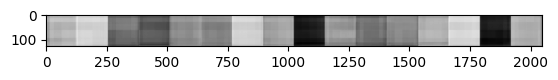

tensor([[0.9995],
        [0.8415],
        [1.0000],
        [0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9939],
        [0.7971],
        [1.0000],
        [0.0162]], grad_fn=<SigmoidBackward0>)


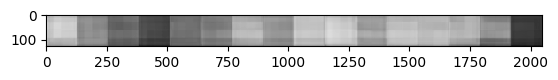

tensor(0)
tensor(52.3604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[8.7139e-19],
        [1.3831e-30],
        [3.7323e-28],
        [2.4414e-16]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


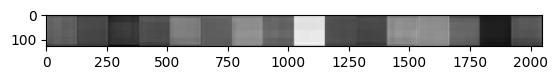

tensor([[2.9074e-15],
        [2.2257e-23],
        [3.1899e-32],
        [1.3072e-17]], grad_fn=<SigmoidBackward0>)
tensor([[7.6900e-25],
        [6.1063e-18],
        [1.0186e-19],
        [1.3020e-31]], grad_fn=<SigmoidBackward0>)


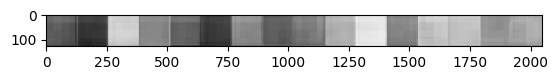

tensor(0)
tensor(40.7860, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[4.3760e-32],
        [1.4862e-14],
        [3.1371e-15],
        [6.8823e-12]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


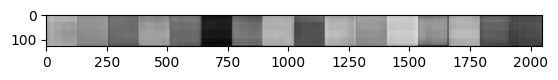

tensor([[1.5383e-13],
        [9.4510e-30],
        [3.3623e-13],
        [1.8796e-17]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000e+00],
        [7.3089e-06],
        [8.3925e-11],
        [3.8576e-14]], grad_fn=<SigmoidBackward0>)


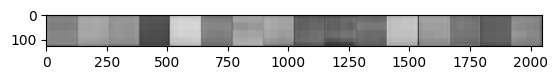

tensor(3)
tensor(0.7216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.0000],
        [0.0558],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


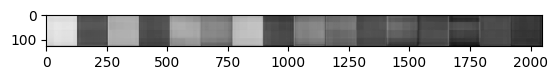

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.0895]], grad_fn=<SigmoidBackward0>)
tensor([[0.9998],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


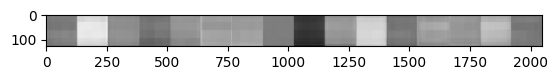

tensor(3)
tensor(25.1584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.0000],
        [0.5307],
        [0.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


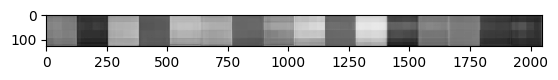

tensor([[9.9982e-01],
        [1.1362e-23],
        [0.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SigmoidBackward0>)


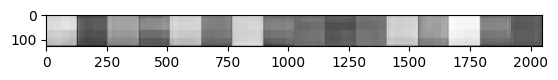

tensor(0)
tensor(58.5411, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000e+00],
        [8.1915e-20],
        [6.0635e-13],
        [1.0890e-27]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


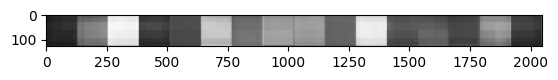

tensor([[1.9995e-31],
        [0.0000e+00],
        [2.2697e-12],
        [4.7624e-27]], grad_fn=<SigmoidBackward0>)
tensor([[2.9737e-15],
        [4.6626e-35],
        [5.9163e-10],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)


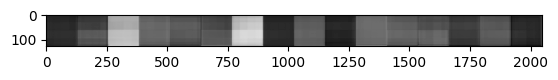

tensor(1)
tensor(37.3156, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.0000e+00],
        [1.0583e-10],
        [0.0000e+00],
        [3.8109e-12]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


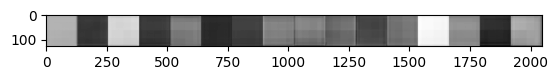

tensor([[1.6578e-35],
        [9.9999e-01],
        [1.9584e-14],
        [2.0240e-10]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000e+00],
        [1.3965e-28],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


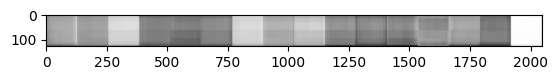

tensor(0)
tensor(55.7108, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000e+00],
        [5.7247e-28],
        [1.9422e-10],
        [4.0155e-17]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


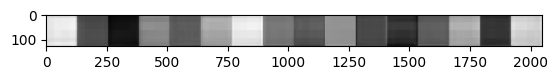

tensor([[3.4721e-09],
        [0.0000e+00],
        [5.7715e-30],
        [2.2015e-18]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000e+00],
        [3.4188e-10],
        [7.4635e-11],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)


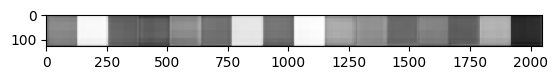

tensor(2)
tensor(20.1429, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[4.8618e-26],
        [2.7096e-10],
        [7.7342e-01],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)
epoch 0 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


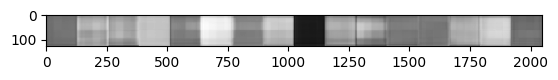

tensor([[8.1714e-04],
        [1.9660e-28],
        [1.0000e+00],
        [9.9814e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [0.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


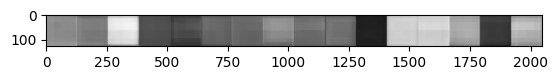

tensor(0)
tensor(37.1324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[3.2289e-09],
        [6.7491e-16],
        [1.9162e-11],
        [7.4753e-31]], grad_fn=<SigmoidBackward0>)
Epoch 0:
	Generator and encoder train loss: 36.42992242177328
	Discriminator train loss: 24.58819646305508
	Generator and encoder train accuracy: 351.5469970703125
	Discriminator train accuracy: 0.5555555820465088
	Generator and encoder val loss: 35.619117736816406
	Discriminator val loss: 2.7785141468048096
	Generator and encoder val accuracy: 345.56488037109375
	Discriminator val accuracy: 0.6111111111111112


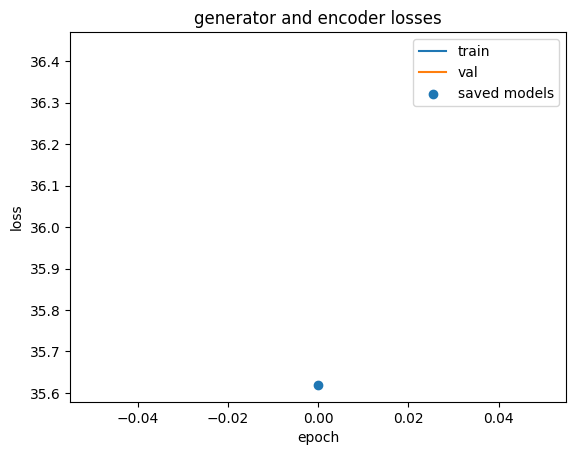

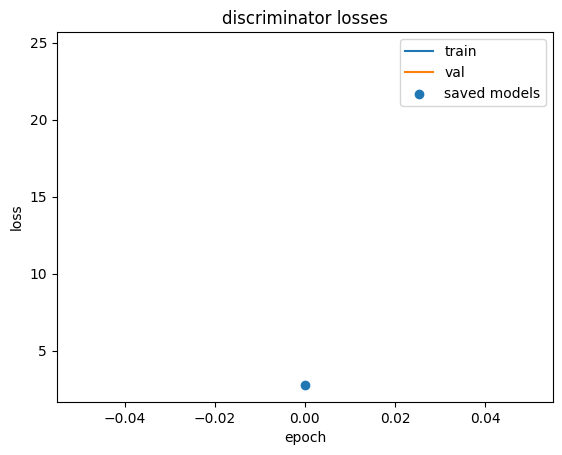

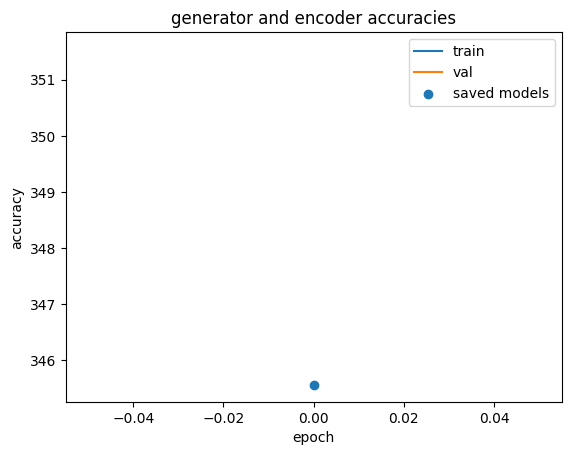

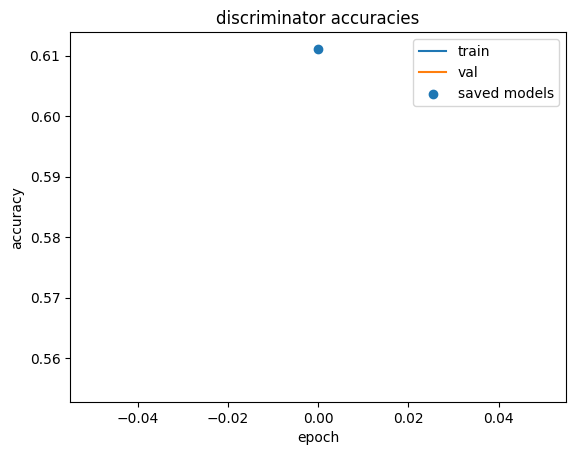

epoch 1 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


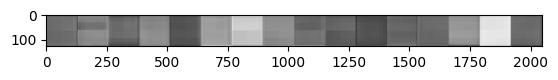

tensor([[9.9830e-01],
        [6.3205e-08],
        [4.7882e-31],
        [1.2880e-29]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [0.0000],
        [0.3780]], grad_fn=<SigmoidBackward0>)


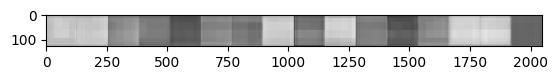

tensor(0)
tensor(45.2751, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.7804e-09],
        [1.6954e-22],
        [2.0247e-33],
        [2.3405e-16]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


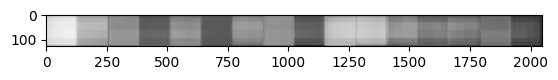

tensor([[1.9943e-01],
        [2.1847e-17],
        [3.0774e-21],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
tensor([[3.0760e-11],
        [8.7701e-10],
        [0.0000e+00],
        [1.5708e-10]], grad_fn=<SigmoidBackward0>)


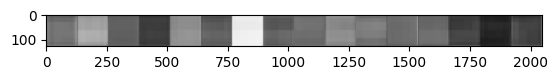

tensor(2)
tensor(7.9882, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[9.6834e-01],
        [1.0000e+00],
        [3.9397e-09],
        [3.4805e-06]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


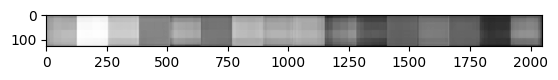

tensor([[6.6821e-04],
        [9.9999e-01],
        [1.2833e-07],
        [9.0499e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [1.0000e+00],
        [7.5319e-37],
        [7.8042e-04]], grad_fn=<SigmoidBackward0>)


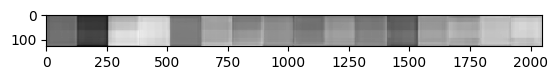

tensor(1)
tensor(12.7818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.3035e-06],
        [5.2979e-12],
        [5.1190e-06],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


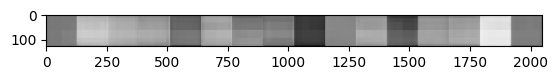

tensor([[9.9969e-01],
        [1.1065e-04],
        [9.9992e-01],
        [4.9270e-19]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [1.0000e+00],
        [1.1830e-28],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


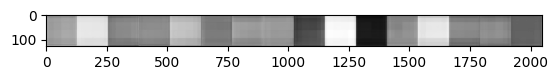

tensor(0)
tensor(48.5237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[3.3540e-19],
        [9.8274e-24],
        [2.4901e-16],
        [6.1860e-28]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


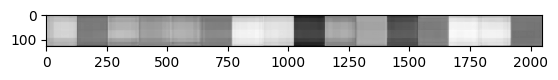

tensor([[2.3409e-20],
        [8.6657e-20],
        [6.0937e-23],
        [1.7592e-23]], grad_fn=<SigmoidBackward0>)
tensor([[2.3724e-25],
        [7.1601e-19],
        [2.1994e-13],
        [4.8983e-14]], grad_fn=<SigmoidBackward0>)


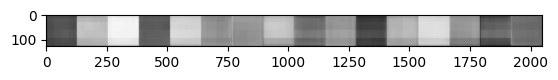

tensor(1)
tensor(2.4513, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0084],
        [0.9999],
        [0.1191],
        [0.0552]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


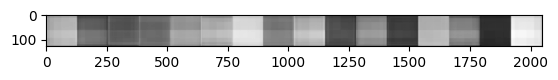

tensor([[9.7977e-01],
        [6.3306e-06],
        [9.8169e-01],
        [9.0264e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [4.3869e-15],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


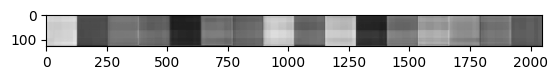

tensor(0)
tensor(51.5936, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[7.6636e-12],
        [1.1060e-14],
        [7.4806e-22],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


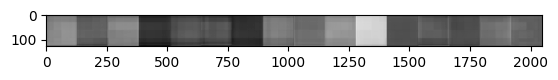

tensor([[5.0989e-20],
        [1.4709e-14],
        [0.0000e+00],
        [8.6880e-17]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000e+00],
        [9.9887e-01],
        [8.2455e-01],
        [2.9074e-33]], grad_fn=<SigmoidBackward0>)


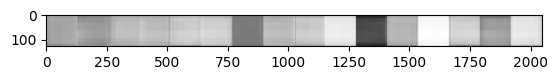

tensor(3)
tensor(25.0673, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000],
        [0.8011],
        [0.9645],
        [0.9886]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


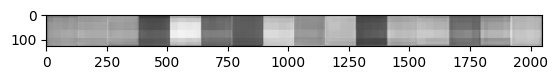

tensor([[9.9991e-01],
        [2.4944e-34],
        [8.8958e-05],
        [1.2481e-32]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [0.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


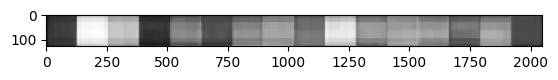

tensor(0)
tensor(54.1877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.4016e-35],
        [1.2486e-32],
        [1.0226e-18],
        [8.9929e-11]], grad_fn=<SigmoidBackward0>)
epoch 1 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


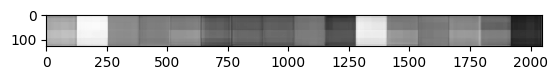

tensor([[1.9246e-34],
        [3.3167e-06],
        [9.8104e-38],
        [8.9493e-20]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


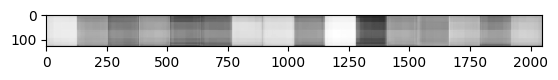

tensor(0)
tensor(49.6074, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000e+00],
        [6.0132e-24],
        [3.2802e-01],
        [9.0694e-20]], grad_fn=<SigmoidBackward0>)
Epoch 1:
	Generator and encoder train loss: 33.05291689766778
	Discriminator train loss: 14.547588878207737
	Generator and encoder train accuracy: 352.2165222167969
	Discriminator train accuracy: 0.625
	Generator and encoder val loss: 47.959343380398224
	Discriminator val loss: 4.237410545349121
	Generator and encoder val accuracy: 347.1066589355469
	Discriminator val accuracy: 0.7777777777777778


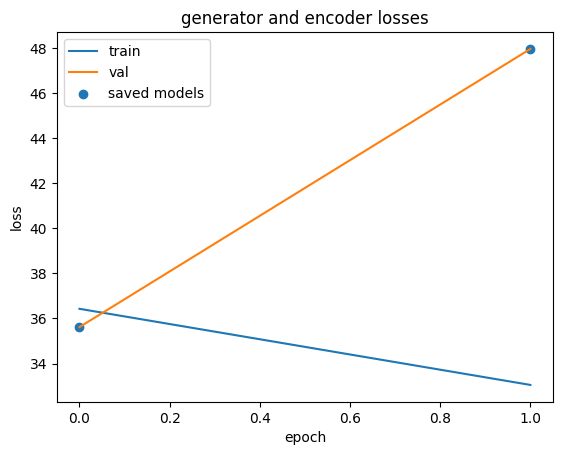

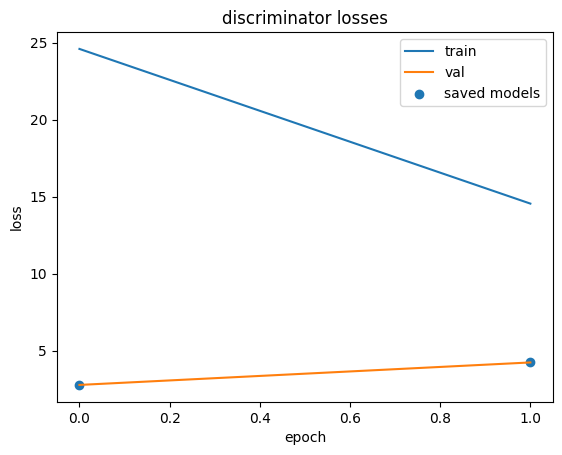

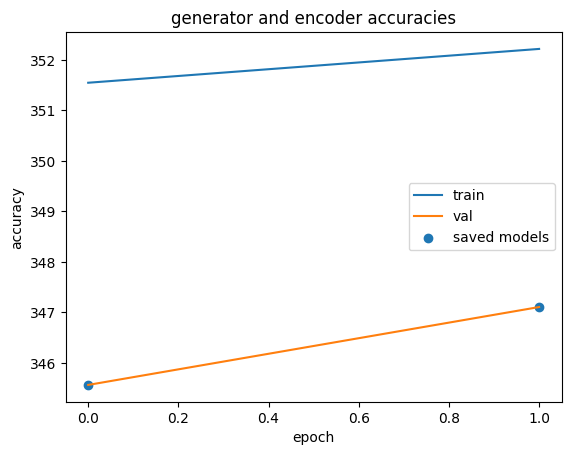

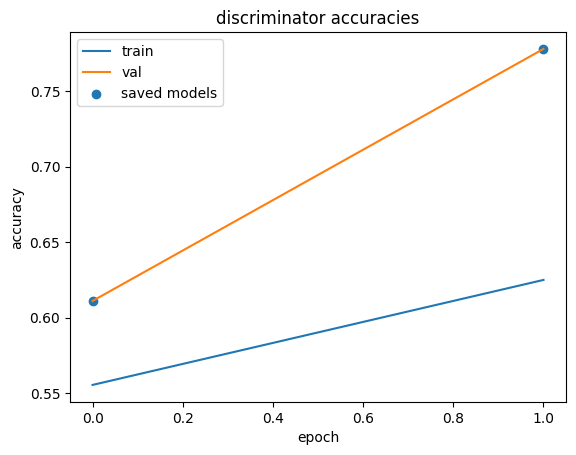

epoch 2 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


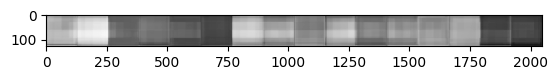

tensor([[1.5275e-05],
        [0.0000e+00],
        [7.1773e-30],
        [7.3792e-11]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000],
        [1.0000],
        [0.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


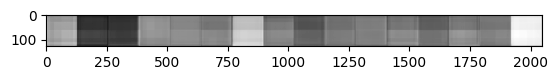

tensor(0)
tensor(48.2652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000e+00],
        [3.2675e-04],
        [3.3642e-25],
        [3.4925e-13]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


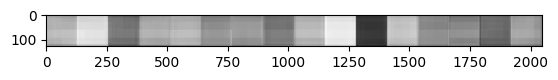

tensor([[6.9665e-07],
        [5.2730e-18],
        [0.0000e+00],
        [8.5233e-16]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


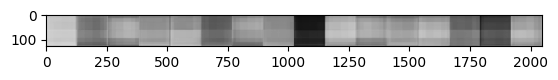

tensor(0)
tensor(50.1112, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.2833e-08],
        [3.9002e-11],
        [0.0000e+00],
        [4.7641e-26]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


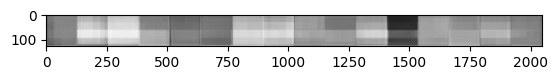

tensor([[1.6449e-07],
        [0.0000e+00],
        [5.6170e-13],
        [6.3824e-27]], grad_fn=<SigmoidBackward0>)
tensor([[0.0000],
        [0.9253],
        [0.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


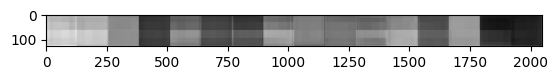

tensor(1)
tensor(38.6386, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.2203e-16],
        [9.9934e-01],
        [4.3176e-22],
        [7.8782e-31]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


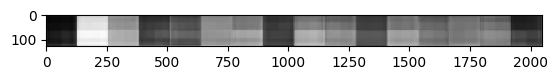

tensor([[6.0239e-07],
        [2.4505e-11],
        [1.5659e-19],
        [1.1542e-25]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


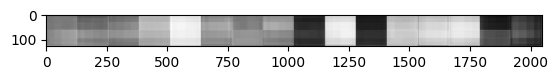

tensor(0)
tensor(37.0368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.0065e-21],
        [1.0712e-08],
        [2.5729e-22],
        [8.2760e-15]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


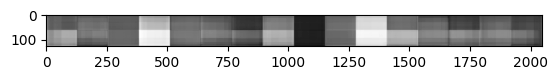

tensor([[7.6456e-03],
        [2.3653e-07],
        [0.0000e+00],
        [3.7607e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


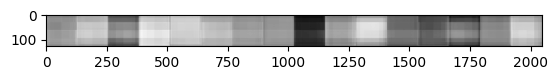

tensor(0)
tensor(59.9810, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.8209e-17],
        [3.0853e-32],
        [1.5414e-21],
        [7.3254e-36]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


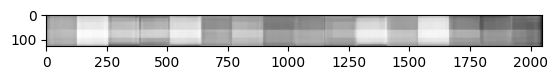

tensor([[2.3792e-04],
        [4.9867e-08],
        [0.0000e+00],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
tensor([[1.3894e-35],
        [1.0000e+00],
        [1.0000e+00],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)


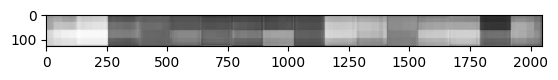

tensor(0)
tensor(62.7856, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[9.4303e-21],
        [4.8622e-17],
        [0.0000e+00],
        [4.9918e-30]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


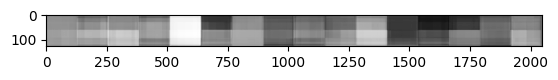

tensor([[0.0000e+00],
        [1.5663e-15],
        [0.0000e+00],
        [2.7798e-17]], grad_fn=<SigmoidBackward0>)
tensor([[6.8276e-22],
        [0.0000e+00],
        [7.4312e-01],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


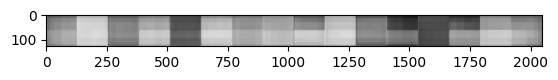

tensor(0)
tensor(37.8575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.5783e-09],
        [0.0000e+00],
        [2.6589e-02],
        [1.0997e-12]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


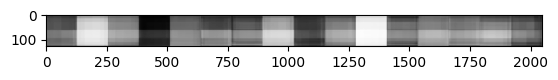

tensor([[0.0000e+00],
        [4.3690e-03],
        [7.8708e-17],
        [3.8947e-19]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


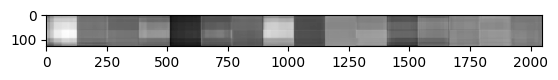

tensor(0)
tensor(65.6452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.7107e-32],
        [8.8200e-27],
        [0.0000e+00],
        [4.1664e-14]], grad_fn=<SigmoidBackward0>)
epoch 2 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


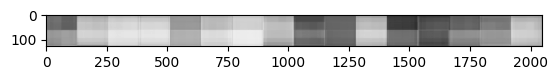

tensor([[2.0316e-38],
        [0.0000e+00],
        [2.2621e-24],
        [3.3103e-22]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [1.]], grad_fn=<SigmoidBackward0>)


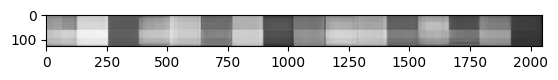

tensor(0)
tensor(65.3205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.1314e-26],
        [1.2937e-21],
        [0.0000e+00],
        [6.1761e-24]], grad_fn=<SigmoidBackward0>)
Epoch 2:
	Generator and encoder train loss: 51.737965477837456
	Discriminator train loss: 18.47022310892741
	Generator and encoder train accuracy: 359.3011169433594
	Discriminator train accuracy: 0.8055555820465088
	Generator and encoder val loss: 68.8685531616211
	Discriminator val loss: 2.7777833938598633
	Generator and encoder val accuracy: 344.7864990234375
	Discriminator val accuracy: 0.8194444444444444


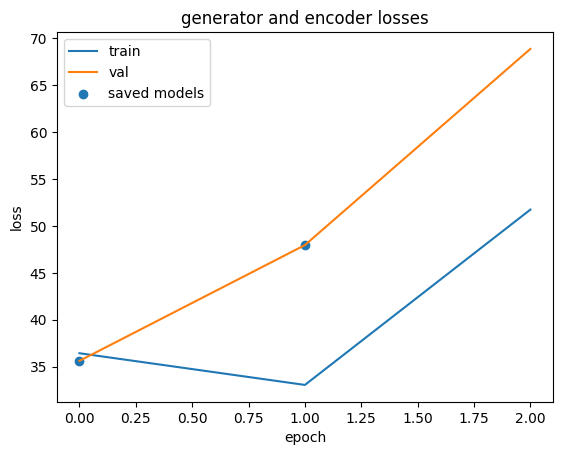

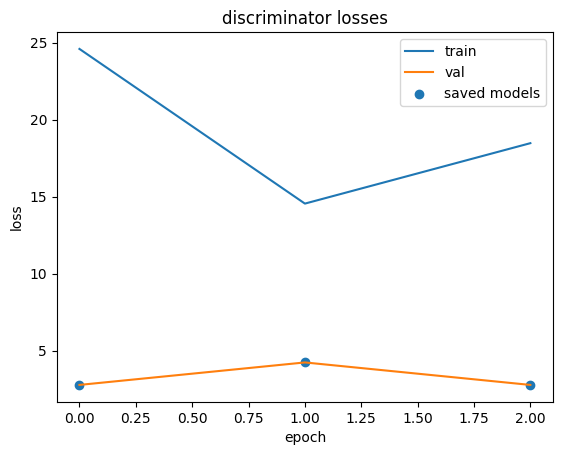

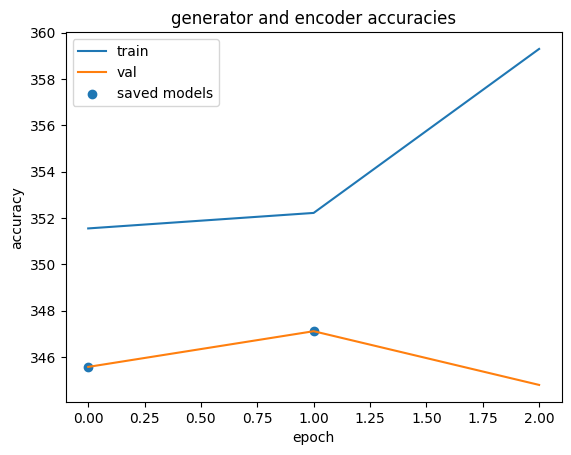

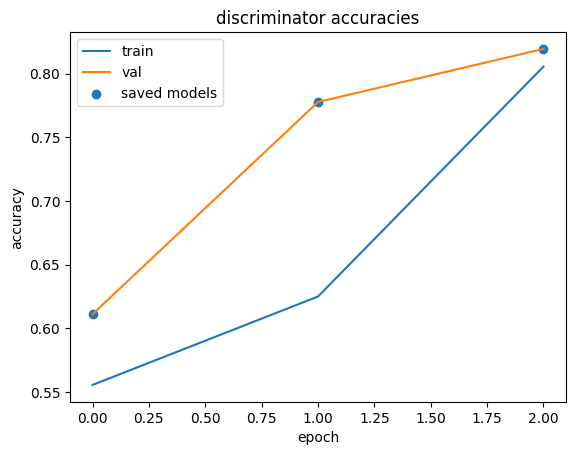

epoch 3 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


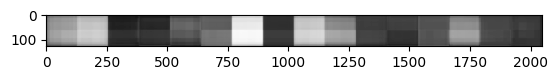

tensor([[0.0000e+00],
        [2.7024e-16],
        [9.7839e-37],
        [1.9567e-33]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [0.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


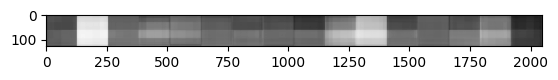

tensor(0)
tensor(65.9398, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[5.5267e-31],
        [1.5729e-19],
        [0.0000e+00],
        [8.7325e-23]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


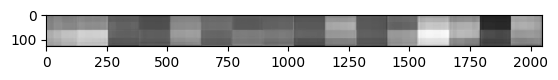

tensor([[2.4186e-25],
        [1.1646e-27],
        [7.4803e-22],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [5.4409e-02],
        [2.0835e-13],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)


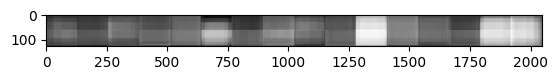

tensor(0)
tensor(48.1363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.8759e-19],
        [1.3171e-08],
        [2.2109e-27],
        [2.8559e-31]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


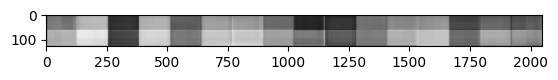

tensor([[8.5330e-33],
        [2.1409e-09],
        [2.2231e-24],
        [1.4714e-16]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SigmoidBackward0>)


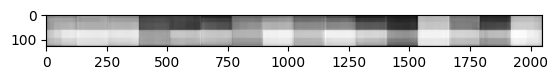

tensor(0)
tensor(47.0831, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[8.5000e-22],
        [1.8788e-29],
        [1.0584e-12],
        [9.5583e-21]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


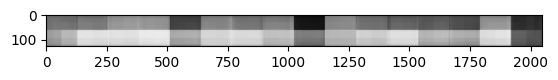

tensor([[1.2337e-07],
        [1.9070e-31],
        [9.4783e-28],
        [2.5298e-15]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [4.6155e-17],
        [0.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


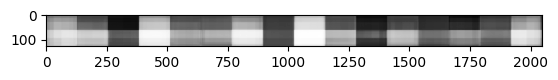

tensor(1)
tensor(20.3349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[9.4750e-01],
        [4.6323e-11],
        [1.3760e-21],
        [7.8292e-05]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


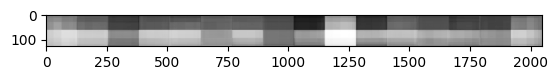

tensor([[7.7610e-10],
        [9.9621e-01],
        [1.6158e-10],
        [6.9096e-12]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [1.0000e+00],
        [3.4050e-19],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


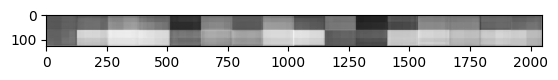

tensor(0)
tensor(58.9186, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.0253e-23],
        [3.9356e-26],
        [5.0394e-12],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


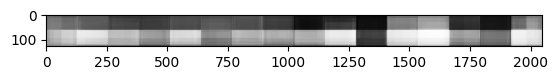

tensor([[0.0000e+00],
        [5.8500e-20],
        [1.5624e-26],
        [8.0938e-17]], grad_fn=<SigmoidBackward0>)
tensor([[2.9150e-04],
        [1.0000e+00],
        [9.9999e-01],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)


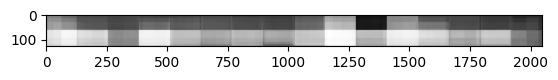

tensor(0)
tensor(26.4003, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[3.2878e-12],
        [6.6538e-22],
        [9.4580e-05],
        [6.6418e-10]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


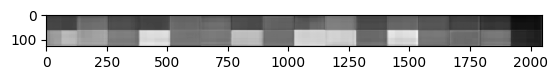

tensor([[3.3245e-19],
        [3.3488e-12],
        [6.0905e-10],
        [3.6451e-06]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000e+00],
        [2.7179e-32],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


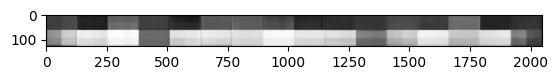

tensor(0)
tensor(26.0626, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.6031e-10],
        [1.5667e-14],
        [1.3680e-05],
        [1.5435e-17]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


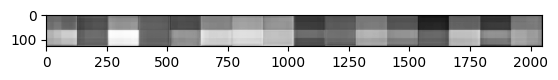

tensor([[9.6136e-19],
        [5.9743e-16],
        [3.9726e-02],
        [9.9278e-11]], grad_fn=<SigmoidBackward0>)
tensor([[1.7216e-19],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


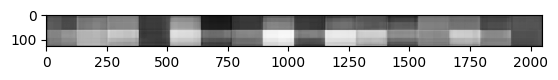

tensor(0)
tensor(54.4956, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[8.8793e-31],
        [2.0283e-15],
        [2.7316e-23],
        [4.3595e-28]], grad_fn=<SigmoidBackward0>)
epoch 3 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


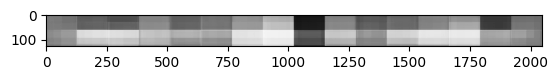

tensor([[2.3304e-27],
        [8.8346e-28],
        [8.4711e-29],
        [1.5062e-21]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SigmoidBackward0>)


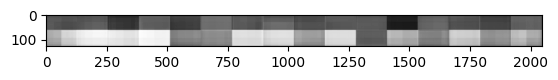

tensor(0)
tensor(59.9181, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.6456e-23],
        [1.1638e-38],
        [3.1399e-21],
        [1.3567e-23]], grad_fn=<SigmoidBackward0>)
Epoch 3:
	Generator and encoder train loss: 45.254359775119354
	Discriminator train loss: 11.692982090844048
	Generator and encoder train accuracy: 365.1035461425781
	Discriminator train accuracy: 0.8055555820465088
	Generator and encoder val loss: 57.2576060824924
	Discriminator val loss: 2.0251126289367676
	Generator and encoder val accuracy: 362.66986083984375
	Discriminator val accuracy: 0.8055555555555556


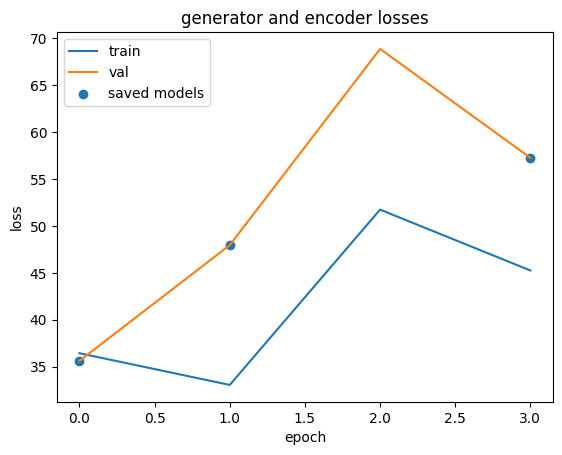

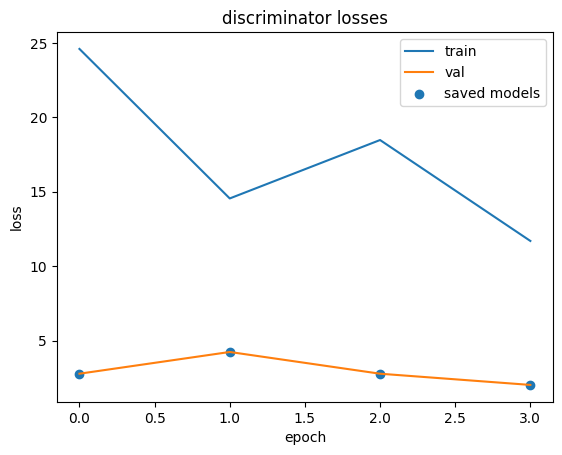

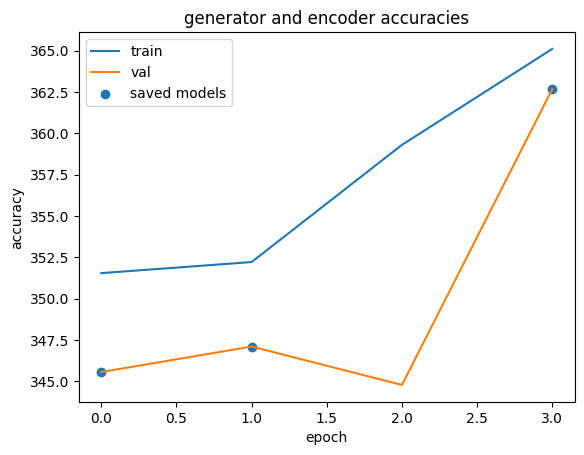

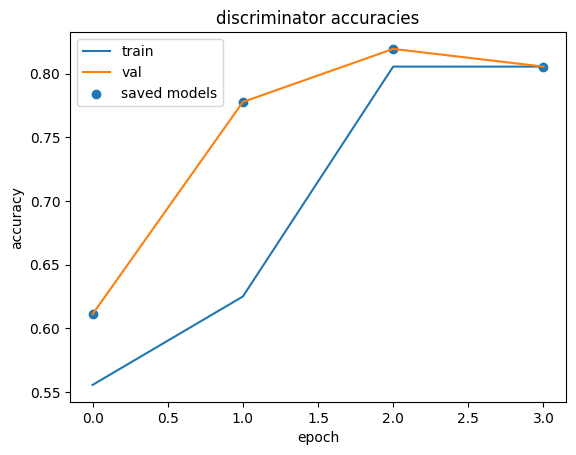

epoch 4 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


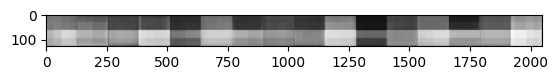

tensor([[3.7288e-36],
        [2.3126e-25],
        [4.5211e-17],
        [6.1608e-26]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [0.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


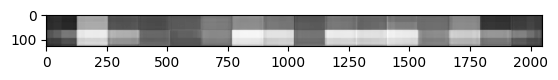

tensor(0)
tensor(57.5519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.5404e-16],
        [2.1000e-30],
        [7.8995e-35],
        [4.1178e-21]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


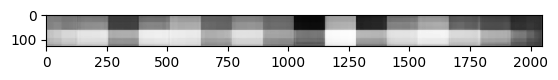

tensor([[2.5926e-23],
        [6.8974e-31],
        [1.3983e-29],
        [2.7820e-19]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SigmoidBackward0>)


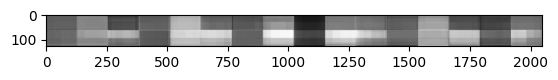

tensor(0)
tensor(57.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.1999e-27],
        [5.6892e-25],
        [6.8036e-26],
        [9.0158e-24]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


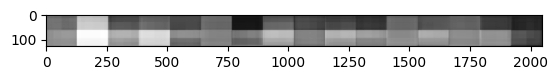

tensor([[1.0846e-38],
        [1.4289e-12],
        [1.2977e-34],
        [1.3949e-16]], grad_fn=<SigmoidBackward0>)
tensor([[1.2363e-18],
        [4.8527e-17],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


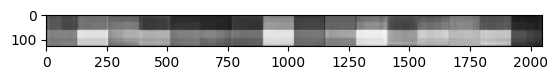

tensor(0)
tensor(30.5664, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[9.9344e-17],
        [2.7546e-15],
        [6.7341e-20],
        [4.3183e-04]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


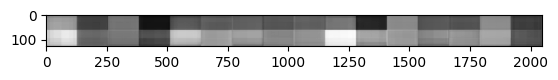

tensor([[4.1810e-14],
        [6.5293e-22],
        [1.1691e-05],
        [2.5971e-12]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


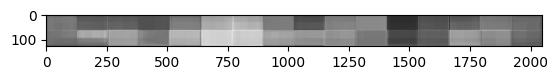

tensor(0)
tensor(35.1498, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[3.5629e-16],
        [1.3572e-18],
        [3.1370e-16],
        [5.7215e-13]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


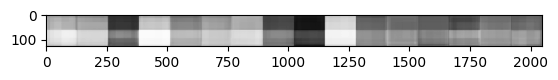

tensor([[1.2183e-15],
        [1.8146e-12],
        [4.1182e-16],
        [1.6265e-20]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [0.9999],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


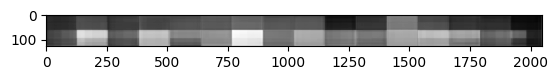

tensor(2)
tensor(2.0456, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0023],
        [0.1251],
        [0.9779],
        [1.0000]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


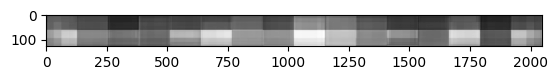

tensor([[0.0082],
        [1.0000],
        [0.3234],
        [0.9986]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


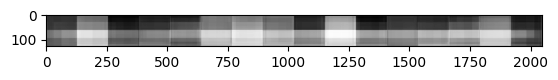

tensor(0)
tensor(55.1966, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.8729e-28],
        [8.6064e-23],
        [1.5969e-32],
        [5.0469e-15]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


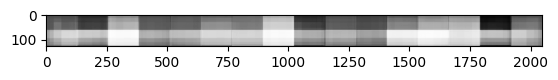

tensor([[5.2839e-25],
        [1.5130e-23],
        [3.8106e-28],
        [1.1173e-23]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [0.9989],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


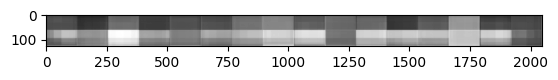

tensor(0)
tensor(36.6607, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.7445e-15],
        [2.5019e-16],
        [3.3300e-13],
        [3.6655e-22]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


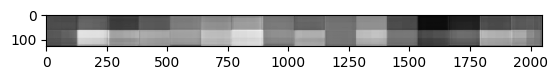

tensor([[5.5600e-13],
        [2.3890e-13],
        [5.8282e-17],
        [3.3924e-25]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


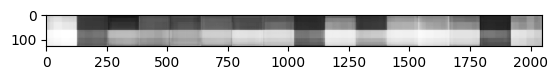

tensor(0)
tensor(37.7960, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.2919e-16],
        [5.3122e-22],
        [4.1889e-13],
        [7.6387e-17]], grad_fn=<SigmoidBackward0>)
epoch 4 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


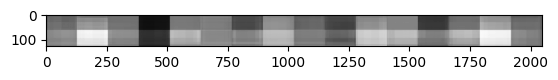

tensor([[5.2088e-13],
        [2.7578e-19],
        [3.7725e-18],
        [9.1883e-16]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


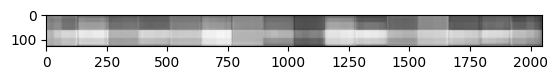

tensor(0)
tensor(34.0320, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[7.1567e-23],
        [2.0162e-08],
        [1.8948e-16],
        [2.7766e-14]], grad_fn=<SigmoidBackward0>)
Epoch 4:
	Generator and encoder train loss: 38.450462341308594
	Discriminator train loss: 5.358397716244433
	Generator and encoder train accuracy: 365.9154357910156
	Discriminator train accuracy: 0.9166666865348816
	Generator and encoder val loss: 33.28376494513618
	Discriminator val loss: 8.643305255545686e-13
	Generator and encoder val accuracy: 349.478759765625
	Discriminator val accuracy: 1.0


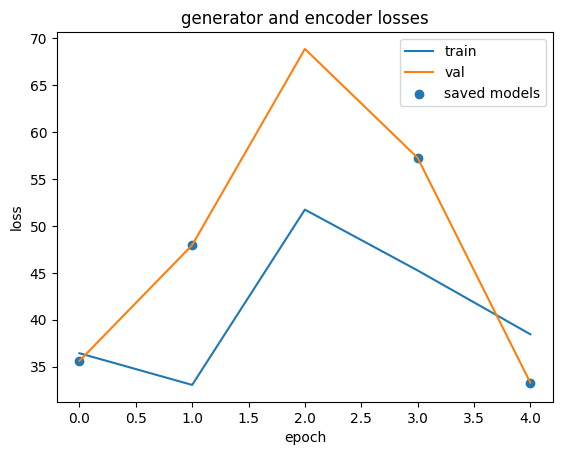

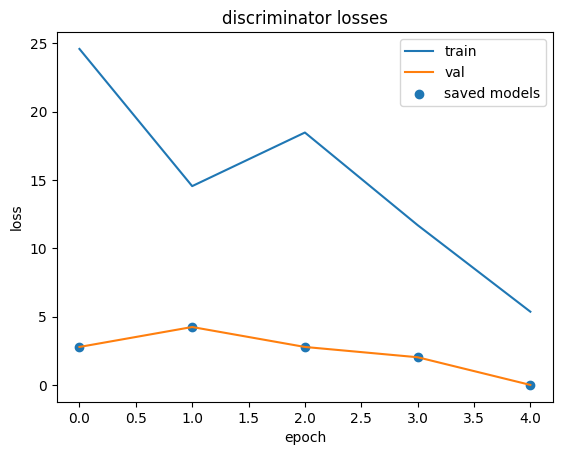

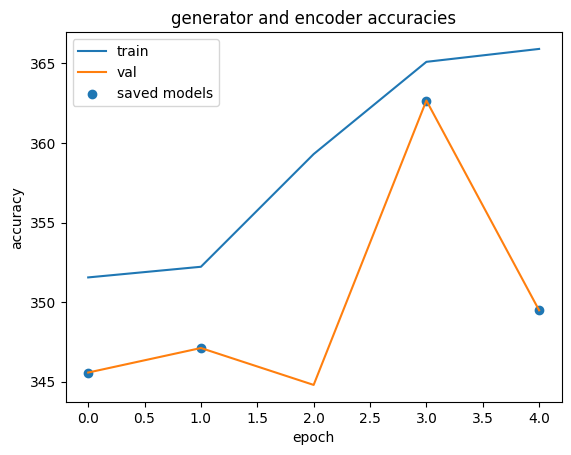

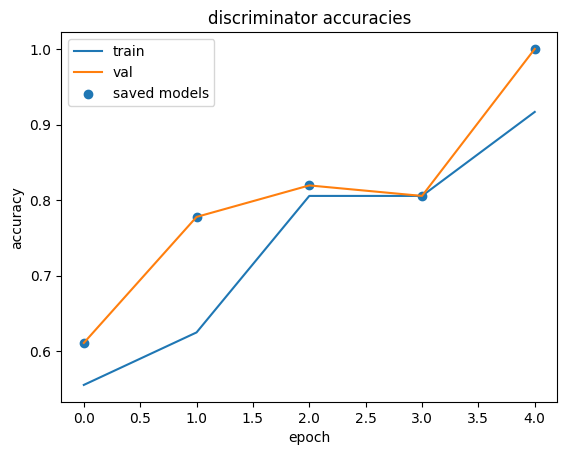

epoch 5 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


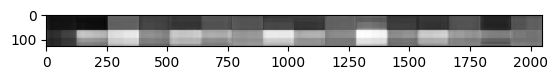

tensor([[5.0446e-17],
        [3.8149e-19],
        [3.8292e-15],
        [5.1798e-10]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


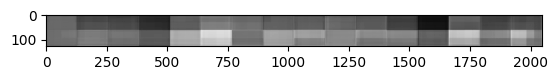

tensor(0)
tensor(34.8650, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.7679e-11],
        [2.8525e-16],
        [5.8244e-22],
        [9.2350e-14]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


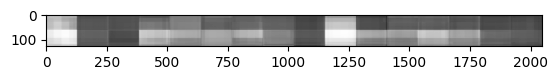

tensor([[4.5928e-15],
        [3.4429e-15],
        [1.3965e-19],
        [1.4853e-13]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


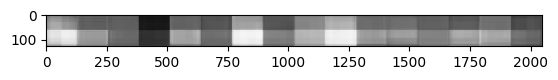

tensor(0)
tensor(35.1274, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.4147e-12],
        [1.9435e-14],
        [5.1639e-21],
        [6.6870e-16]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


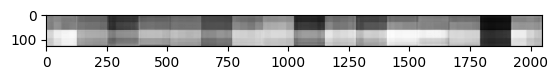

tensor([[5.0526e-17],
        [3.0284e-13],
        [5.4223e-16],
        [1.2716e-15]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SigmoidBackward0>)


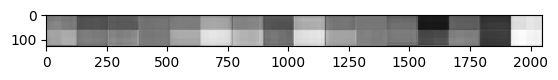

tensor(0)
tensor(33.1509, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.8090e-10],
        [3.5762e-13],
        [1.3762e-17],
        [2.8939e-19]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


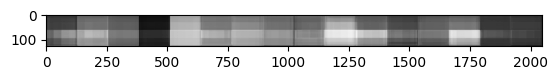

tensor([[4.2356e-14],
        [6.7084e-16],
        [4.5046e-14],
        [1.2462e-10]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


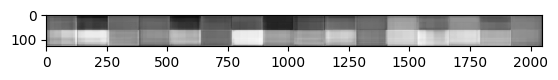

tensor(0)
tensor(34.7706, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.8534e-16],
        [6.3087e-15],
        [3.9421e-13],
        [2.3210e-19]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


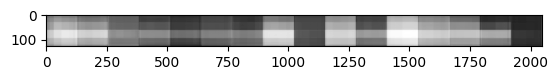

tensor([[1.3473e-11],
        [5.9412e-15],
        [1.0869e-14],
        [1.8532e-19]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


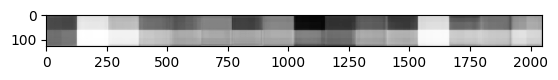

tensor(0)
tensor(31.5752, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.7065e-19],
        [1.1879e-17],
        [9.6404e-10],
        [4.5396e-11]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


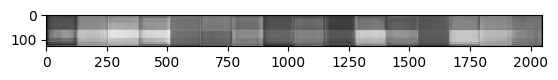

tensor([[1.1459e-13],
        [1.1466e-11],
        [7.7711e-16],
        [2.1717e-14]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


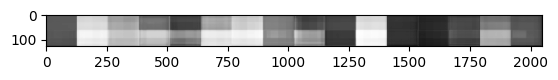

tensor(0)
tensor(28.1283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[3.3614e-09],
        [1.2313e-14],
        [3.6888e-11],
        [8.9618e-17]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


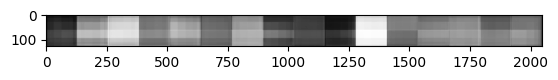

tensor([[9.6509e-11],
        [1.5919e-09],
        [3.8816e-20],
        [2.9702e-08]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


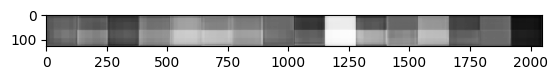

tensor(0)
tensor(23.3856, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.6982e-10],
        [1.4512e-08],
        [1.8364e-11],
        [5.2413e-13]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


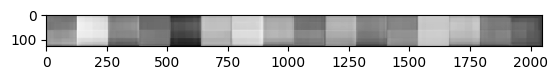

tensor([[2.1660e-05],
        [4.5104e-05],
        [3.0494e-09],
        [6.2490e-05]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


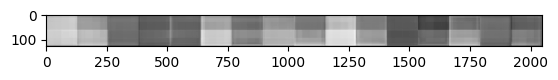

tensor(0)
tensor(85.1122, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[5.5689e-35],
        [0.0000e+00],
        [4.7891e-34],
        [1.4073e-37]], grad_fn=<SigmoidBackward0>)
epoch 5 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


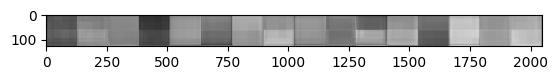

tensor([[2.8251e-30],
        [1.9781e-34],
        [0.0000e+00],
        [0.0000e+00]], grad_fn=<SigmoidBackward0>)
tensor([[1.4364e-05],
        [2.0967e-30],
        [1.0000e+00],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)


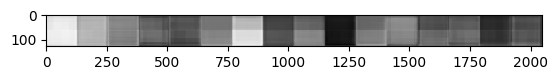

tensor(0)
tensor(62.7967, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.3702e-25],
        [3.9071e-29],
        [1.9389e-28],
        [7.8493e-29]], grad_fn=<SigmoidBackward0>)
Epoch 5:
	Generator and encoder train loss: 40.990194744533966
	Discriminator train loss: 1.1040016886046269
	Generator and encoder train accuracy: 365.2205505371094
	Discriminator train accuracy: 0.9722222089767456
	Generator and encoder val loss: 61.62598334418403
	Discriminator val loss: 0.08376213908195496
	Generator and encoder val accuracy: 355.8798522949219
	Discriminator val accuracy: 0.9305555555555556


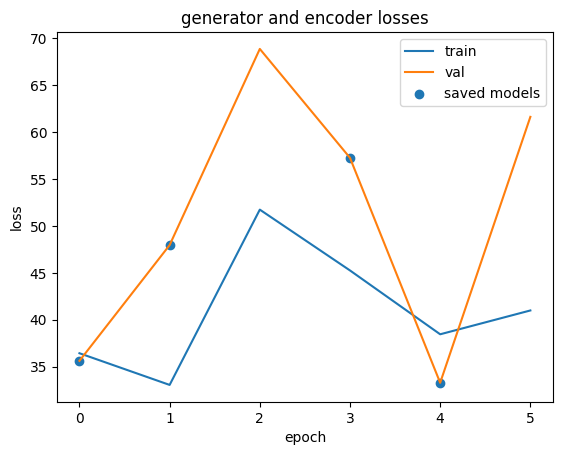

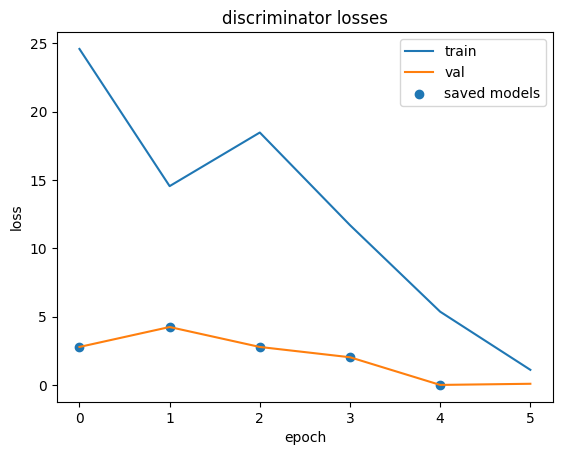

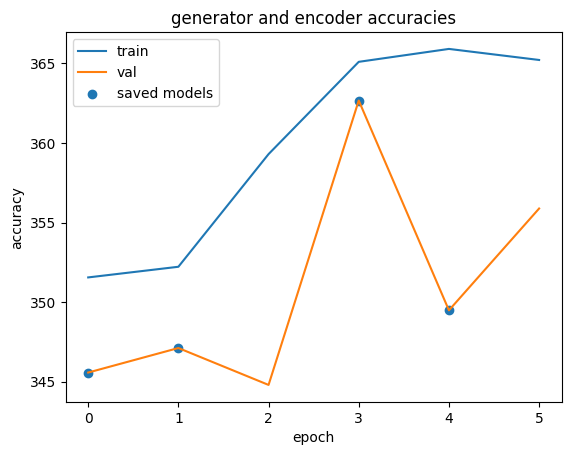

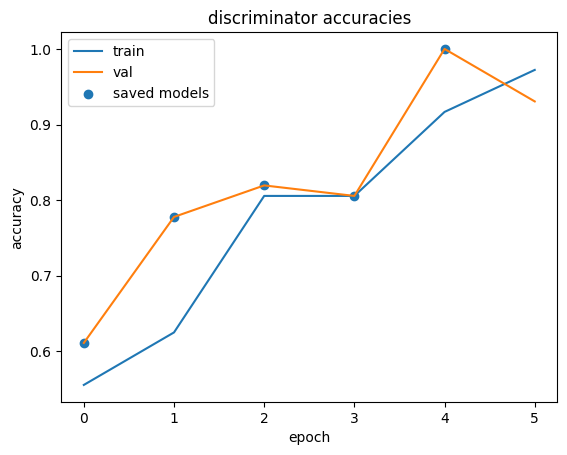

epoch 6 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


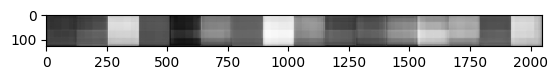

tensor([[2.6879e-25],
        [1.0754e-28],
        [7.4646e-29],
        [2.5818e-25]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000],
        [1.0000],
        [0.2389],
        [1.0000]], grad_fn=<SigmoidBackward0>)


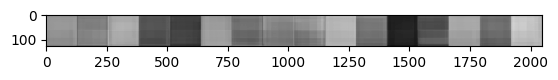

tensor(2)
tensor(9.8801, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.9730e-11],
        [1.0000e+00],
        [9.9867e-01],
        [9.8565e-08]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 1
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


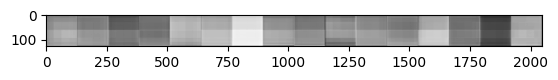

tensor([[9.9986e-01],
        [1.0000e+00],
        [3.2745e-10],
        [3.1875e-02]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


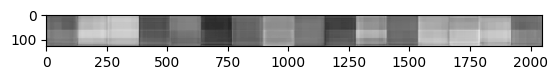

tensor(0)
tensor(67.1992, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[4.7172e-32],
        [4.0041e-33],
        [5.0839e-29],
        [1.9081e-25]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 2
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


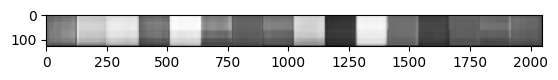

tensor([[1.8433e-23],
        [2.9608e-37],
        [7.4757e-31],
        [3.9820e-27]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


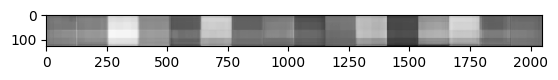

tensor(0)
tensor(69.6492, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[2.8826e-29],
        [3.6821e-28],
        [0.0000e+00],
        [2.5735e-22]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 3
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


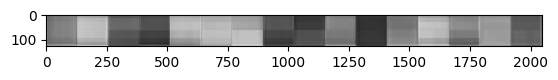

tensor([[4.8109e-20],
        [5.4309e-21],
        [0.0000e+00],
        [1.9493e-31]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


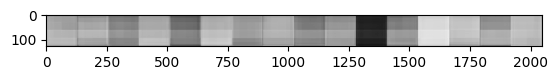

tensor(0)
tensor(71.0745, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[0.0000e+00],
        [7.3702e-28],
        [6.1999e-24],
        [1.9980e-30]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 4
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


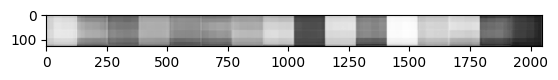

tensor([[6.4428e-39],
        [4.4863e-22],
        [4.4471e-33],
        [4.6213e-21]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


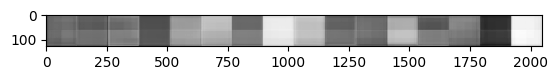

tensor(0)
tensor(65.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[8.2698e-32],
        [1.2922e-33],
        [7.9681e-28],
        [1.1371e-23]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 5
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


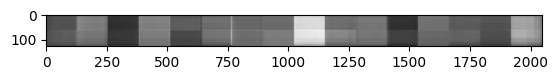

tensor([[8.1635e-25],
        [1.1152e-32],
        [1.8851e-28],
        [6.1258e-33]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


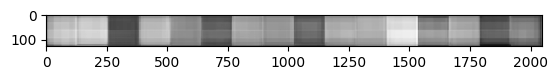

tensor(0)
tensor(68.1388, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.9297e-37],
        [9.4525e-25],
        [2.3142e-31],
        [1.0123e-27]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 6
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


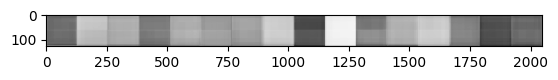

tensor([[1.6500e-37],
        [4.3858e-22],
        [2.7002e-34],
        [1.4291e-23]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


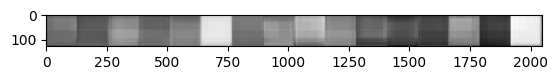

tensor(0)
tensor(67.6908, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[6.7207e-30],
        [4.4923e-34],
        [7.7831e-29],
        [1.0912e-27]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 7
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


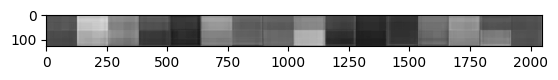

tensor([[3.0396e-21],
        [1.4353e-36],
        [7.0066e-38],
        [1.5783e-23]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


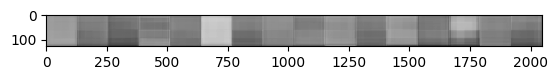

tensor(0)
tensor(65.8379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[5.6825e-24],
        [8.2218e-29],
        [1.7974e-29],
        [5.0538e-35]], grad_fn=<SigmoidBackward0>)
epoch 6 batch 8
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


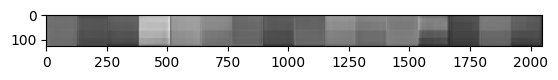

tensor([[2.5809e-22],
        [6.0168e-30],
        [0.0000e+00],
        [2.1218e-24]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)


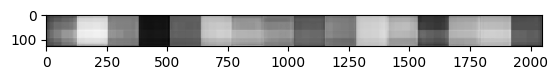

tensor(0)
tensor(69.4224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([[1.4216e-33],
        [7.0241e-22],
        [1.0604e-36],
        [2.3771e-31]], grad_fn=<SigmoidBackward0>)
Epoch 6:
	Generator and encoder train loss: 61.61385949452718
	Discriminator train loss: 1.5328606449895434
	Generator and encoder train accuracy: 365.30462646484375
	Discriminator train accuracy: 0.9583333134651184
	Generator and encoder val loss: 65.5107298956977
	Discriminator val loss: 4.813465539613341e-27
	Generator and encoder val accuracy: 349.80181884765625
	Discriminator val accuracy: 1.0


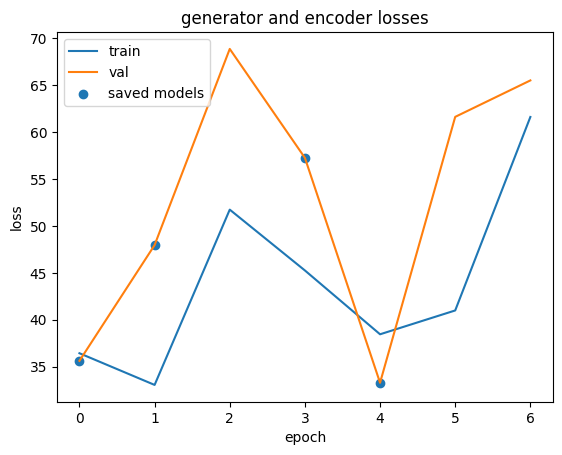

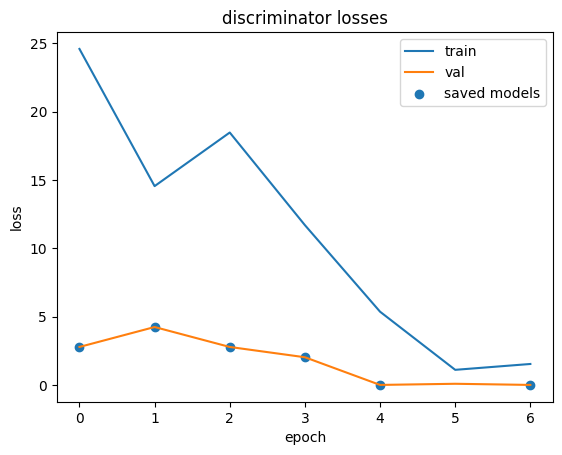

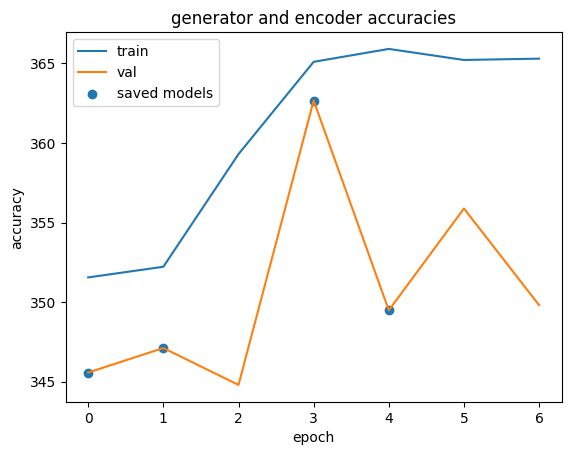

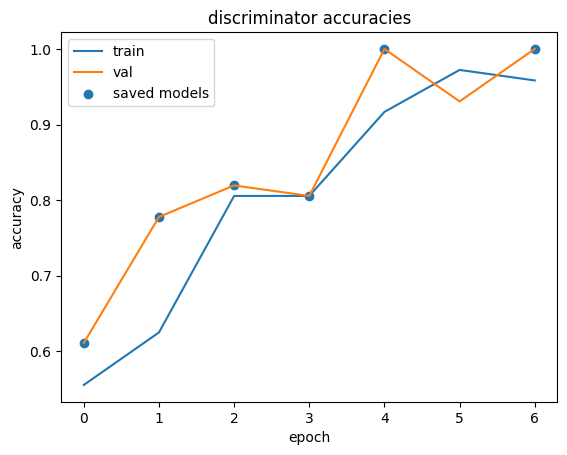

epoch 7 batch 0
real_image_batch.shape torch.Size([4, 1, 128, 2048])
input_text_batch.shape torch.Size([4, 82])
torch.Size([4, 128]) torch.Size([4, 256])


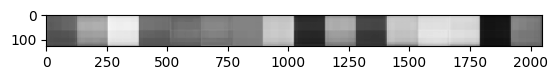

In [15]:
generator = Generator()
discriminator = Discriminator()
encoder = Encoder()

train_gan( num_epochs=10, batch_size=4, encoder=encoder, generator=generator ,discriminator=discriminator, train_real_image_dataset=line_image_dataset_train, val_real_image_dataset=line_image_dataset_val, train_input_text_dataset=line_transcription_dataset_train, val_input_text_dataset=line_transcription_dataset_val, recognizer=None)